## ЗАХИСТ

## Лабораторна робота № 5
### Моделювання та оцінювання гетероскедастичних процесів 

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd


%matplotlib inline
plt.rcParams["figure.figsize"] = (6,6)
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append("../")

In [3]:
from Lab_1.metrics import *

give me a bottle of rum!


In [4]:
from arch import arch_model

In [5]:
def read_data_from_file(file_path):
    with open(file_path) as file:
        content = file.read()   
    content = content.split('\n')
    return list(map(float, content))

In [6]:
def create_feature_matrix(x, ar):
        len_matr = x.shape[0] - ar
        feature_matrix = pd.DataFrame({"intercept":np.ones((1,len_matr))[0]}, index = range(len_matr))
        for i in range(1, ar+1):
            feature_matrix[f"y(k-{i})"] = x[ar-i:-i]
        y = x[ar:]
        return y, feature_matrix

In [7]:
def lsm(y, feature):

        feature_matrix=feature.to_numpy()
        inform_matr = np.linalg.pinv(feature_matrix.T@feature_matrix)
        inform_matr = inform_matr @ feature_matrix.T
        return inform_matr@y

In [8]:
def plot_acf(y:list, nlags:int = 24, label = None):
    '''
    Plot the ACF/PACF
    Params:
        y: list (time series)
        nlags: number of lags to use in computations
        label: label to show in the title of plot
    '''
    fig, ax = plt.subplots(1, 2,figsize=(10, 5))
    ax[0].bar(range(nlags+1),acf(y, nlags = nlags));
    ax[1].bar(range(nlags+1),pacf(y, nlags = nlags));
    ax[0].set_title(r"ACF of "+label)
    ax[1].set_title(r"PACF of "+label)
    fig.show();

In [9]:
def calc_result(y:list, matr:pd.DataFrame, p:int, q:int):
    '''
    Calculates the estimation of coefficients of different models and prints some of the results.
    Parameters:
        y: actual time series
        matr: matrix of features
    Returns:
        fitted: fitted values of model
    '''
    coefs = lsm(y, matr)
    fitted = matr.to_numpy()@coefs
    eq_matr = matr.columns.copy()
    eq_matr = [f"{round(coefs[i], 5)}{'*'+eq_matr[i] if eq_matr[i] != 'intercept' else ''}" 
               for i in range(len(eq_matr))]
    eq = ""
    for i in range(len(eq_matr)):
        eq += "+ "+eq_matr[i] if coefs[i] > 0 and i!= 0 else " "+eq_matr[i]
        eq += " "
    print(f"Equation: {eq}")
    print(f"RSS: {RSS(y, fitted)}")
    print(f"R^2: {R_squared(y, fitted)}")
    print(f"IKA: {IKA(y, fitted, p, q)}")
    return fitted

In [10]:
def cond_var(ts:list):
    '''
    Computation of conditional variance to determine the q lag in GARCH model
    Params:
        data: time series in list format
    Returns:
        h: list of conditional variances
    '''
    h = []
    np_ts = np.array(ts)
    
    for k in range(2, len(ts)):
        sub_ts = np_ts[:k]
        mean_sub_ts = sub_ts.mean()
        h.append(sub_ts.var())
    
    return h

In [11]:
def create_feature_matrix_garch(h:list, eps:list, p:int = 1, q:int = 1):
    '''
    Creation of feature matrix to estimate the GARCH model
    Parameters:
        h: list of conditional variances
        eps: list of residuals
        p: number of lags of h(k)
        q: number of lags of eps_sq(k)
    Returns:
        y: list of h(k) 
        feature_matrix: the created feature matrix
    '''
    k = max(p, q)
    np_h = np.array(h).copy()
    len_matr = np_h.shape[0] - k
    eps_sq =  (np.array(eps).copy()**2)[2:]
    feature_matrix = pd.DataFrame({"intercept":np.ones((1,len_matr))[0]}, index = range(len_matr))
    for i in range(1, q+1):
        feature_matrix[f"eps_sq(k-{i})"] = eps_sq[q-i:-i-(k - q)]
    for j in range(1, p+1):
        feature_matrix[f"h(k-{j})"] = np_h[p-j:-j - (k - p)]
    y = np_h[-len_matr:]
    return y, feature_matrix

### Завантаження даних

In [12]:
close = pd.read_csv('data/close.txt')['<CLOSE>']

In [13]:
close

0      1.7006
1      1.7055
2      1.7508
3      1.7677
4      1.7483
        ...  
396    1.9685
397    1.9736
398    2.0248
399    2.0500
400    2.0385
Name: <CLOSE>, Length: 401, dtype: float64

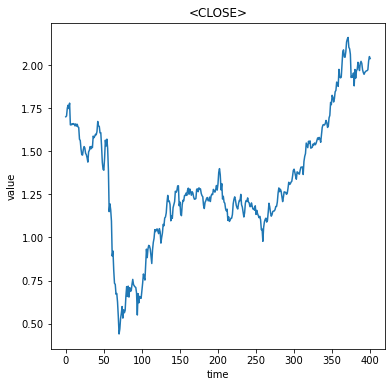

In [14]:
plt.plot(close)
plt.xlabel('time')
plt.ylabel('value')
plt.title('<CLOSE>')
plt.show();

In [15]:
close.describe()

count    401.000000
mean       1.325419
std        0.369457
min        0.440000
25%        1.135400
50%        1.261900
75%        1.565000
max        2.160900
Name: <CLOSE>, dtype: float64

### AP

In [16]:
pacf(close, nlags =24, method = 'ldb')

array([ 1.        ,  0.98783285, -0.03486103, -0.07288542,  0.01853641,
       -0.02251184, -0.01075101, -0.00255554, -0.02440396, -0.02661034,
       -0.05059924,  0.00111426, -0.05642264,  0.00793306, -0.07168448,
       -0.01836656,  0.0107893 , -0.01502234,  0.01266902,  0.03123616,
        0.01217266, -0.02505754,  0.06484417, -0.06341434,  0.03579758])

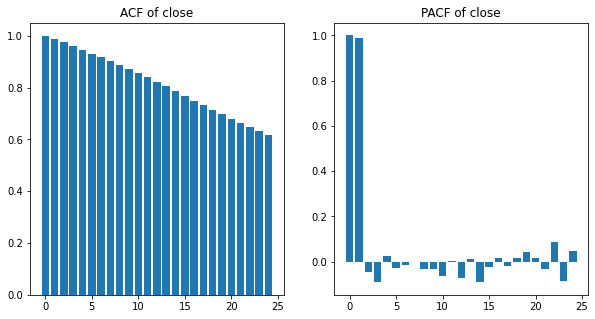

In [17]:
plot_acf(close, label = "close")

p = 1

In [18]:
ar_c = ARIMA(close, order= ([1], 0 , 0))
ar_c = ar_c.fit()
ar_c_predict = ar_c.predict()
ar_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                <CLOSE>   No. Observations:                  401
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 707.933
Date:                Mon, 26 Apr 2021   AIC                          -1409.866
Time:                        14:27:52   BIC                          -1397.884
Sample:                             0   HQIC                         -1405.122
                                - 401                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6703      0.983      1.699      0.089      -0.257       3.598
ar.L1          0.9971      0.004    256.166      0.000       0.989       1.005
sigma2         0.0017   7.17e-05     23.585      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):               455.67
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

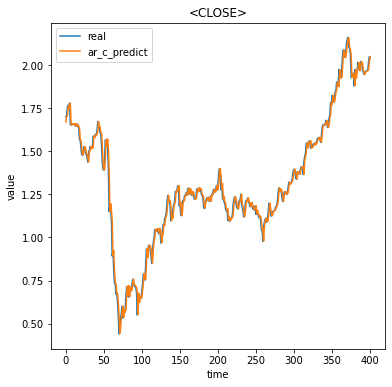

In [19]:
plt.plot(close, label = 'real')
plt.xlabel('time')
plt.ylabel('value')
plt.title('<CLOSE>')

plt.plot(ar_c_predict, label = 'ar_c_predict')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show();

### Залишок 

In [20]:
resid_close = close - ar_c_predict

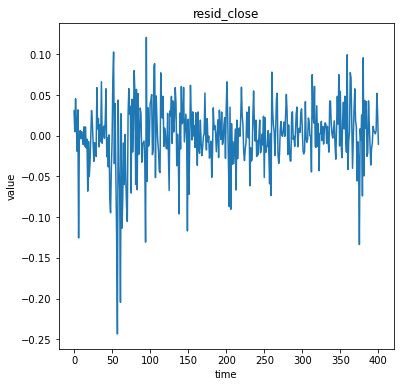

In [21]:
plt.plot(resid_close)
plt.xlabel('time')
plt.ylabel('value')
plt.title('resid_close')
plt.show();

In [22]:
acf(resid_close, nlags=24)

array([ 1.        ,  0.04300734,  0.13524153,  0.0037254 ,  0.05234339,
       -0.01072571,  0.06498443,  0.03902823,  0.04694437,  0.08088826,
       -0.02953143,  0.06458193, -0.03851352,  0.14064737,  0.06410783,
       -0.046891  , -0.01471355,  0.00289712, -0.02913845, -0.00349292,
        0.00335587, -0.02496354,  0.03774314, -0.09288446, -0.01673207])

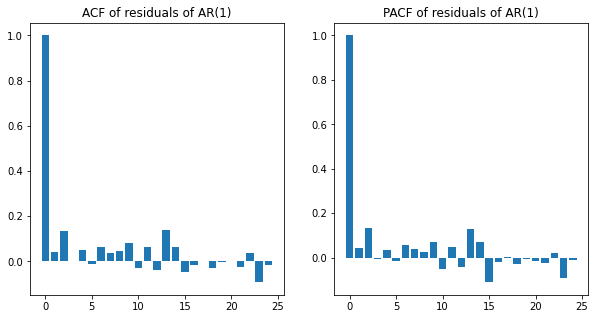

In [23]:
plot_acf(resid_close, label = "residuals of AR(1)")

### Квадрат залишків

In [24]:
resid_close_sqr = resid_close*resid_close

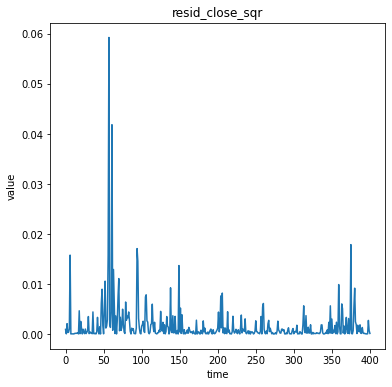

In [25]:
plt.plot(resid_close_sqr)
plt.xlabel('time')
plt.ylabel('value')
plt.title('resid_close_sqr')
plt.show();

In [26]:
pacf(resid_close_sqr, nlags=24)

array([ 1.        ,  0.18476458,  0.04228719,  0.04259643,  0.32278459,
        0.08371067,  0.07369049,  0.02198099, -0.0958198 ,  0.13351286,
       -0.07616991,  0.02540772,  0.12119728, -0.00617932,  0.01391961,
       -0.01728904, -0.07284424, -0.10328254,  0.00252532,  0.01850908,
       -0.00270259,  0.07512049,  0.01396308,  0.00660383,  0.0061012 ])

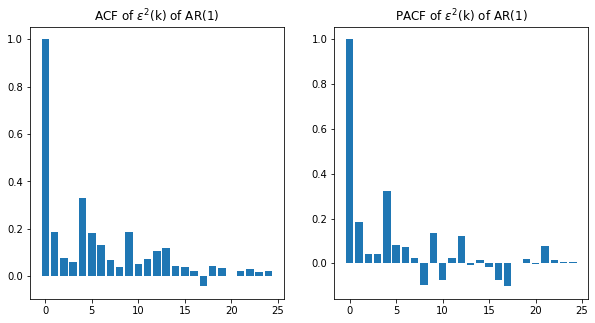

In [27]:
plot_acf(resid_close_sqr, label = r"$\varepsilon^2$(k) of AR(1)")

### Ряд умовних дисперсій

In [28]:
h_close = cond_var(close)
pacf(h_close, nlags = 24)

array([ 1.00000000e+00,  9.96896564e-01, -2.04230604e-01, -1.70658504e-01,
       -1.50094657e-01, -1.22918587e-01, -9.44641506e-02, -8.76309542e-02,
       -7.88910385e-02, -6.62200924e-02, -5.50699837e-02, -4.29945915e-02,
       -3.36542844e-02, -2.92095344e-02, -2.44926372e-02, -2.22698678e-02,
       -1.68872911e-02, -1.41985996e-02, -5.64816215e-03, -8.22308962e-03,
       -3.00102144e-03, -8.22989845e-04, -9.90901170e-03, -2.07370130e-02,
       -2.62273094e-02])

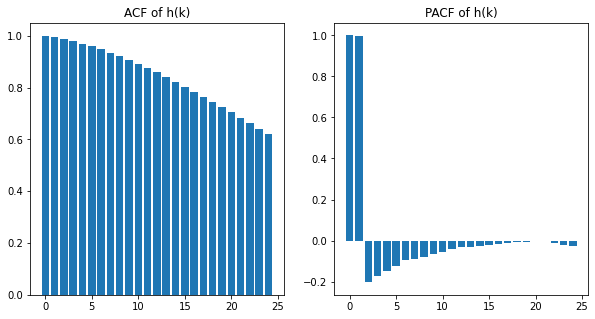

In [29]:
plot_acf(h_close, label = "h(k)")

### УАРУГ

За АКФ $\varepsilon^2(k)$ та $h(k)$ візьмемо $p = 2,q = 4$

In [30]:
h_c, garch_matr_c = create_feature_matrix_garch(h_close, resid_close, p = 2, q = 4)

In [31]:
garch_matr_c.head()

,intercept,eps_sq(k-1),eps_sq(k-2),eps_sq(k-3),eps_sq(k-4),h(k-1),h(k-2)
0,1.0,1.006466e-03,3.655437e-04,2.935074e-04,0.002061,0.000511,0.000006
1,1.0,1.577142e-02,1.006466e-03,3.655437e-04,0.000294,0.000828,0.000511
2,1.0,4.191512e-07,1.577142e-02,1.006466e-03,0.000366,0.000710,0.000828
3,1.0,3.907313e-05,4.191512e-07,1.577142e-02,0.001006,0.000875,0.000710
4,1.0,1.392020e-05,3.907313e-05,4.191512e-07,0.015771,0.001703,0.000875


In [32]:
garch_1_fitted = calc_result(h_c, garch_matr_c, 2, 4)

Equation:  0.00035 + 0.06504*eps_sq(k-1) + 0.0864*eps_sq(k-2) + 0.11601*eps_sq(k-3)  -0.01466*eps_sq(k-4) + 3.75292*h(k-1)  -2.75972*h(k-2) 
RSS: 0.000682595368662111
R^2: 0.9993875644853406
IKA: -2865.395281013633


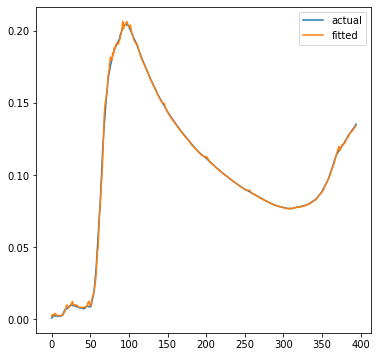

In [33]:
plt.plot(h_c, label = "actual")
plt.plot(garch_1_fitted, label = "fitted")
plt.legend()
plt.show();

### Модель гетероскедастичного процесу

In [34]:
cond_res_sq = cond_var(resid_close)

In [35]:
pacf(cond_res_sq, nlags = 24)

array([ 1.        ,  0.9665491 ,  0.04713185, -0.04562348,  0.07489945,
       -0.05552957,  0.4269703 , -0.01353281, -0.06234217,  0.05874999,
       -0.09979544,  0.20030414, -0.03699211, -0.15378425,  0.03658562,
       -0.14813386,  0.06900722, -0.02453473, -0.12846855,  0.03435327,
       -0.11161632,  0.03219985,  0.00186393, -0.08450701,  0.05210454])

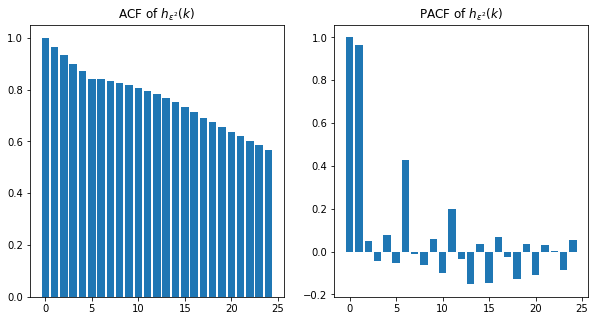

In [36]:
plot_acf(cond_res_sq, label = r"$h_{\varepsilon^2}(k)$")

За АКФ $\varepsilon^2(k)$ та $h(k)$ візьмемо $p = 11,q = 4$

In [37]:
h_res, garch_matr_res = create_feature_matrix_garch(cond_res_sq, resid_close, p = 11, q = 4)

In [38]:
garch_matr_res.head()

,intercept,eps_sq(k-1),eps_sq(k-2),eps_sq(k-3),eps_sq(k-4),h(k-1),h(k-2),h(k-3),h(k-4),h(k-5),h(k-6),h(k-7),h(k-8),h(k-9),h(k-10),h(k-11)
0,1.0,1.006466e-03,3.655437e-04,2.935074e-04,0.002061,0.001709,0.001865,0.002047,0.002274,0.002551,0.002915,0.000439,0.000485,0.000226,0.000278,0.000160
1,1.0,1.577142e-02,1.006466e-03,3.655437e-04,0.000294,0.001585,0.001709,0.001865,0.002047,0.002274,0.002551,0.002915,0.000439,0.000485,0.000226,0.000278
2,1.0,4.191512e-07,1.577142e-02,1.006466e-03,0.000366,0.001482,0.001585,0.001709,0.001865,0.002047,0.002274,0.002551,0.002915,0.000439,0.000485,0.000226
3,1.0,3.907313e-05,4.191512e-07,1.577142e-02,0.001006,0.001392,0.001482,0.001585,0.001709,0.001865,0.002047,0.002274,0.002551,0.002915,0.000439,0.000485
4,1.0,1.392020e-05,3.907313e-05,4.191512e-07,0.015771,0.001314,0.001392,0.001482,0.001585,0.001709,0.001865,0.002047,0.002274,0.002551,0.002915,0.000439


In [39]:
garch_fitted_res = calc_result(h_res, garch_matr_res, p = 11, q = 4)

Equation:  2e-05 + 0.00041*eps_sq(k-1)  -0.00166*eps_sq(k-2) + 0.00168*eps_sq(k-3)  -0.00028*eps_sq(k-4) + 1.12592*h(k-1)  -0.14138*h(k-2)  -0.04191*h(k-3) + 0.42083*h(k-4)  -0.30737*h(k-5)  -0.04685*h(k-6)  -0.02187*h(k-7)  -0.00061*h(k-8)  -0.0081*h(k-9) + 0.0034*h(k-10) + 0.00723*h(k-11) 
RSS: 1.2273671807673588e-06
R^2: 0.9919963594786727
IKA: -5248.9280042351065


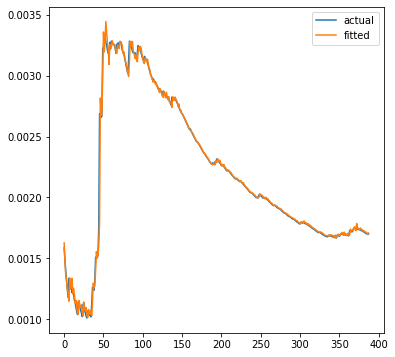

In [40]:
plt.plot(h_res, label = "actual")
plt.plot(garch_fitted_res, label = "fitted")
plt.legend()
plt.show();